In [3]:
from tqdm import tqdm
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms as T
import random
import time

import os
import requests
import zipfile

#Downloading the data

In [ ]:
if not (os.path.isfile("faces.zip") or os.path.isdir("faces")):
    # A part of the total dataset
    url = "https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_100000-133332_5_imgs.zip"
    response = requests.get(url, stream=True)

    with open("/content/drive/MyDrive/faces.zip", "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

In [5]:
# Check if the zip file was already extracted
if not os.path.isdir("faces"):
    with zipfile.ZipFile("/content/drive/MyDrive/faces.zip", "r") as zip_ref:
        zip_ref.extractall("faces")

In [6]:
print(f"Some folders: {os.listdir('faces')[:5]}, there are a total of {len(os.listdir('faces'))} folders.")

Some folders: ['101047', '122469', '119604', '101990', '129977'], there are a total of 33333 folders.


# Plotting Images

In [7]:
def plot_folder(path):
    img_paths = os.listdir(path)

    fig, ax = plt.subplots(1, 5)
    for i, img_path in enumerate(img_paths):
        img = Image.open(path + img_path)
        ax[i].imshow(img)

        ax[i].set_xticks([])
        ax[i].set_yticks([])

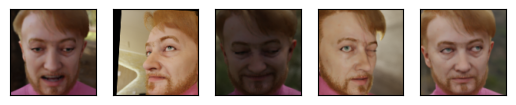

In [16]:
plot_folder("/content/faces/101047/")

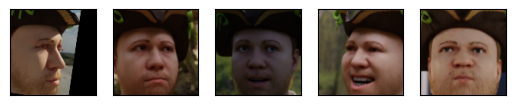

In [17]:
plot_folder("/content/faces/122469/")

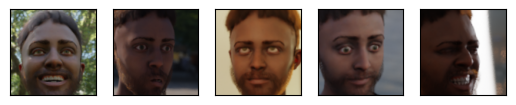

In [18]:
plot_folder("/content/faces/119604/")

# Dataset

In [8]:
class FaceDataset(Dataset):
    def __init__(self, transform, identity_folders):
        # To later prevent data leakage between training and validation sets
        self.identity_folders = identity_folders
        self.transform = transform

    def __len__(self):
        return len(self.identity_folders)

    def get_image(self, path):
        img = Image.open(path)
        img = img.convert("RGB")
        return self.transform(img)

    def __getitem__(self, index):
        # The input index specifies the reference identity
        folder = self.identity_folders[index]
        img_paths = os.listdir(f"faces/{folder}/")

        # Anchor image is chosen from the folder
        anchor_index = random.randint(0, len(img_paths) - 1)
        anchor = self.get_image(f"faces/{folder}/{img_paths[anchor_index]}")

        # Positive image must be different from the anchor, but be the same identity
        positive_index = random.randint(0, len(img_paths) - 1)
        while positive_index == anchor_index:
            positive_index = random.randint(0, len(img_paths) - 1)
        positive = self.get_image(f"faces/{folder}/{img_paths[positive_index]}")

        # Negative image must be a different identity
        negative_folder = random.choice(self.identity_folders)
        while negative_folder == folder:
            negative_folder = random.choice(self.identity_folders)
        img_paths = os.listdir(f"faces/{negative_folder}")

        negative_index = random.randint(0, len(img_paths) - 1)
        negative = self.get_image(f"faces/{negative_folder}/{img_paths[negative_index]}")

        return anchor, positive, negative

In [9]:
dataset = FaceDataset(T.ToTensor(), sorted(os.listdir("faces")))

In [10]:
def plot_triplet(images):
    # Plot the images
    fig, ax = plt.subplots(1, 3)
    labels = ["Anchor", "Positive", "Negative"]
    for i, img in enumerate(images):
        # The shape of the image is changed to (3, 112, 112),
        # for plotting, we need the shape to be (112, 112, 3)
        ax[i].imshow(img.permute(1, 2, 0))

        # Hide the ticks
        ax[i].set_xticks([])
        ax[i].set_yticks([])

        # Add a label
        ax[i].set_title(labels[i])

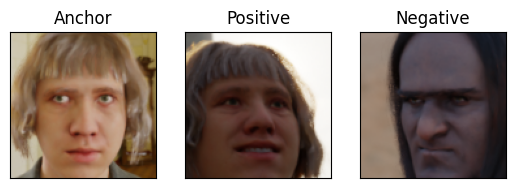

In [23]:
plot_triplet(dataset[0])

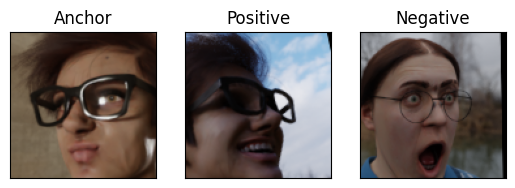

In [24]:
plot_triplet(dataset[1])

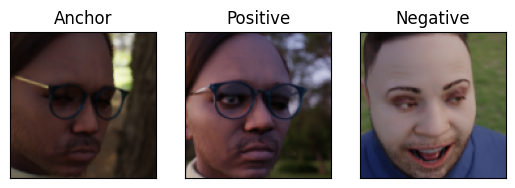

In [25]:
plot_triplet(dataset[2])

# Model training

In [11]:
!pip install torchinfo

In [12]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import torchinfo

In [37]:
backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
torchinfo.summary(backbone, (1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6   

In [38]:
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = {
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": [],
            "train_val_loss": [],
            "train_val_accuracy": [],
        }

    def _train(self, dataloader):
        self.model.train()
        total_loss, correct = 0, 0
        for batch, (a, p, n) in tqdm(enumerate(dataloader)):
            a, p, n = a.to(self.device), p.to(self.device), n.to(self.device)

            # Forward
            p_out, n_out = self.model.triplet_forward(a, p, n)

            # Loss
            loss1 = self.criterion(p_out, torch.ones_like(p_out))
            loss2 = self.criterion(n_out, torch.zeros_like(n_out))
            loss = loss1 + loss2

            # Metrics
            total_loss += loss
            correct += torch.sum(p_out >= 0.5) / p_out.shape[0]
            correct += torch.sum(n_out < 0.5) / n_out.shape[0]

            # Step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        total_loss /= len(dataloader)
        correct = correct / (2 * len(dataloader)) # Each triplet is checked twice

        return total_loss, correct


    def _val(self, dataloader):
        self.model.eval()
        total_loss, correct = 0, 0
        for batch, (a, p, n) in enumerate(dataloader):
            a, p, n = a.to(self.device), p.to(self.device), n.to(self.device)

            # Forward
            with torch.inference_mode():
                p_out, n_out = self.model.triplet_forward(a, p, n)

            # Loss
            loss1 = self.criterion(p_out, torch.ones_like(p_out))
            loss2 = self.criterion(n_out, torch.zeros_like(n_out))
            loss = loss1 + loss2

            # Metrics
            total_loss += loss
            correct += torch.sum(p_out >= 0.5) / p_out.shape[0]
            correct += torch.sum(n_out < 0.5) / n_out.shape[0]


        total_loss /= len(dataloader)
        correct = correct / (2 * len(dataloader)) # Each triplet is checked twice

        return total_loss, correct

    def fit(self, epochs, save_every, train_loader, val_loader, train_val_loader=None, scheduler=None):
        """Fits the model to the given data and plots the results over epochs.

        Args:
            epochs (int): Number of epochs to train the model for.
            train_loader (DataLoader): Dataloader used for training.
            val_loader (DataLoader): Dataloader used for validation.
            save_every (int): The number of epochs to save a checkpoint after.
            train_val_loader (DataLoader): Dataloader used for data mismatch insights.
            scheduler (lr_scheduler): The learning rate scheduler.
        """
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}\n---------")
            self.train_for_one_epoch(train_loader, "train")

            if train_val_loader:
                self.validate_for_one_epoch(train_val_loader, "train_val")

            self.validate_for_one_epoch(val_loader, "val")

            self.save_checkpoint(epoch, save_every)

            if scheduler:
                scheduler.step()

        self.plot_metrics(train_val_loader is not None)

    def train_for_one_epoch(self, data_loader, prefix):
        loss, accuracy = self._train(data_loader)
        self.log_metrics(loss, accuracy, prefix)

    def validate_for_one_epoch(self, data_loader, prefix):
        loss, accuracy = self._val(data_loader)
        self.log_metrics(loss, accuracy, prefix)

    def log_metrics(self, loss, accuracy, prefix):
        print(f"{prefix.capitalize()}: {loss:.4f} loss, {accuracy * 100:.2f}% correct")
        self.metrics[f"{prefix}_loss"].append(loss.cpu().detach())
        self.metrics[f"{prefix}_accuracy"].append(accuracy.cpu().detach())

    def save_checkpoint(self, epoch, save_every):
        if epoch % save_every == save_every - 1:
            torch.save(self.model.state_dict(), "checkpoint.pt")

    def plot_metrics(self, has_train_val):
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        epochs = range(len(self.metrics["train_loss"]))
        self.configure_plot(ax[0], epochs, "Loss", ["train_loss", "val_loss"], ["Training", "Validation"])
        self.configure_plot(ax[1], epochs, "Accuracy", ["train_accuracy", "val_accuracy"], ["Training", "Validation"])

        if has_train_val:
            self.configure_plot(ax[0], epochs, "Loss", ["train_val_loss"], ["Train-Val"])
            self.configure_plot(ax[1], epochs, "Accuracy", ["train_val_accuracy"], ["Train-Val"])

    def configure_plot(self, ax, epochs, title, metric_keys, labels):
        for key, label in zip(metric_keys, labels):
            ax.plot(epochs, self.metrics[key], label=label)
        if title == "Loss":
            ax.legend(loc="upper right")
        else:
            ax.legend(loc="lower right")
        ax.set_title(title)

In [39]:
class SiameseModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        # Load backbone ResNet
        backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        backbone.requires_grad_(False) # Freeze backbone weights

        # Replace the classifier part
        backbone.classifier = nn.Sequential(
            nn.Linear(in_features=960, out_features=256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(in_features=256, out_features=256)
        )

        self.feature_extractor = backbone

        self.logistic = nn.Linear(in_features=256, out_features=1)


    def forward(self, x):
        return self.model.forward(x)

    def predict(self, x1, x2):
        output = self.forward(x1, x2)
        return torch.sigmoid(output) >= 0.5

    def predict_from_output(self, output):
        return torch.sigmoid(output) >= 0.5

    def triplet_forward(self, a, p, n):
        a_out = self.feature_extractor(a)
        p_out = self.feature_extractor(p)
        n_out = self.feature_extractor(n)

        p_out = self.logistic(torch.abs(a_out - p_out))
        n_out = self.logistic(torch.abs(a_out - n_out))
        return p_out, n_out

    def forward(self, x1, x2):
        x1 = self.feature_extractor(x1)
        x2 = self.feature_extractor(x2)
        return self.logistic(torch.abs(x1 - x2))

In [40]:
torch.manual_seed(42)
train_folders, train_val_folders, val_folders = torch.utils.data.random_split(
    sorted(os.listdir("faces")), [0.8, 0.1, 0.1]
)

augment = T.Compose([
    # The magnitude bins determine the strength of augmentation (max 31)
    T.TrivialAugmentWide(num_magnitude_bins=31),
    T.ToTensor(),
])

train_set = FaceDataset(augment, train_folders)
train_val_set = FaceDataset(augment, train_val_folders)
val_set = FaceDataset(T.ToTensor(), val_folders)

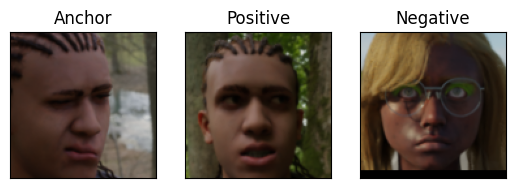

In [36]:
plot_triplet(train_set[0])

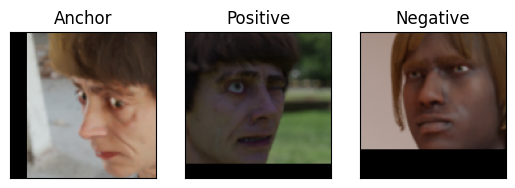

In [37]:
plot_triplet(train_val_set[0])

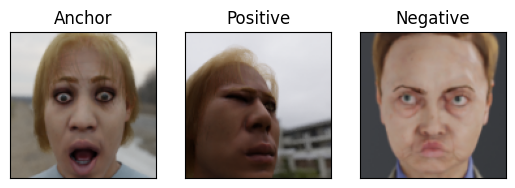

In [38]:
plot_triplet(val_set[0])

In [51]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=1)
train_val_loader = DataLoader(train_val_set, batch_size=64, pin_memory=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size=64, pin_memory=True, num_workers=1)

In [52]:
torch.manual_seed(42)
model_v1 = SiameseModelV1().to('cuda')
# Show the model in detail
torchinfo.summary(model_v1, ((1, 3, 112, 112), (1, 3, 112, 112)))

Layer (type:depth-idx)                                  Output Shape              Param #
SiameseModelV1                                          [1, 1]                    --
├─MobileNetV3: 1-1                                      [1, 256]                  --
│    └─Sequential: 2-1                                  [1, 960, 4, 4]            --
│    │    └─Conv2dNormActivation: 3-1                   [1, 16, 56, 56]           (464)
│    │    └─InvertedResidual: 3-2                       [1, 16, 56, 56]           (464)
│    │    └─InvertedResidual: 3-3                       [1, 24, 28, 28]           (3,440)
│    │    └─InvertedResidual: 3-4                       [1, 24, 28, 28]           (4,440)
│    │    └─InvertedResidual: 3-5                       [1, 40, 14, 14]           (10,328)
│    │    └─InvertedResidual: 3-6                       [1, 40, 14, 14]           (20,992)
│    │    └─InvertedResidual: 3-7                       [1, 40, 14, 14]           (20,992)
│    │    └─InvertedResidu

In [53]:
torch.manual_seed(42)
optimizer = torch.optim.SGD(model_v1.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
trainer = Trainer(model_v1, 'cuda', optimizer, criterion)

Epoch 1
---------


417it [02:47,  2.50it/s]

Train: 1.2348 loss, 57.65% correct


Train_val: 1.0630 loss, 68.58% correct
Val: 0.9704 loss, 72.34% correct
Epoch 2
---------


417it [02:45,  2.51it/s]

Train: 1.0111 loss, 72.15% correct


Train_val: 0.9609 loss, 72.95% correct
Val: 0.8367 loss, 76.62% correct
Epoch 3
---------


417it [02:44,  2.54it/s]

Train: 0.9330 loss, 75.78% correct


Train_val: 0.9278 loss, 76.29% correct
Val: 0.7763 loss, 81.45% correct
Epoch 4
---------


417it [02:40,  2.60it/s]

Train: 0.8872 loss, 77.35% correct


Train_val: 0.8810 loss, 78.15% correct
Val: 0.7188 loss, 83.37% correct
Epoch 5
---------


417it [02:39,  2.62it/s]

Train: 0.8621 loss, 78.52% correct


Train_val: 0.8540 loss, 78.38% correct
Val: 0.6985 loss, 83.71% correct


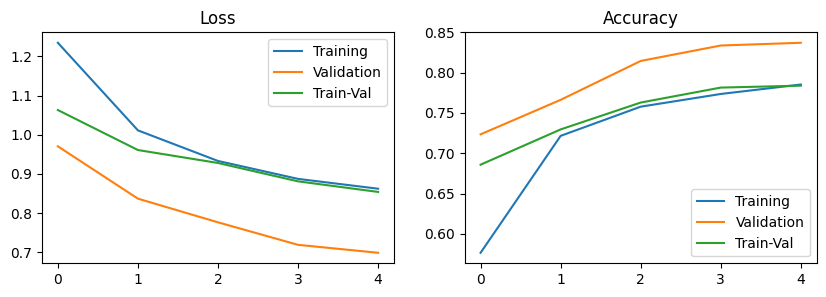

In [54]:
start = time.time()
trainer.fit(
    epochs=5,
    save_every=5,
    train_loader=train_loader,
    val_loader=val_loader,
    train_val_loader=train_val_loader,
)
end = time.time()

In [55]:
print("Time taken to train the model: ", end-start)

Time taken to train the model:  994.9675333499908


# Parallelization

In [19]:
from torch.nn.parallel import DataParallel

Epoch 1
---------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
417it [02:13,  3.13it/s]

Train: 1.2381 loss, 57.58% correct


Train_val: 1.0854 loss, 69.73% correct
Val: 0.9675 loss, 74.20% correct
Epoch 2
---------


417it [02:10,  3.19it/s]

Train: 1.0138 loss, 72.10% correct


Train_val: 0.9528 loss, 75.90% correct
Val: 0.8112 loss, 80.97% correct
Epoch 3
---------


417it [02:10,  3.20it/s]


Train: 0.9258 loss, 75.95% correct
Train_val: 0.9121 loss, 77.30% correct
Val: 0.7751 loss, 81.87% correct
Epoch 4
---------


417it [02:10,  3.20it/s]


Train: 0.8942 loss, 77.14% correct
Train_val: 0.8743 loss, 76.42% correct
Val: 0.7260 loss, 81.11% correct
Epoch 5
---------


417it [02:10,  3.19it/s]

Train: 0.8675 loss, 78.35% correct


Train_val: 0.8723 loss, 76.70% correct
Val: 0.6893 loss, 82.02% correct


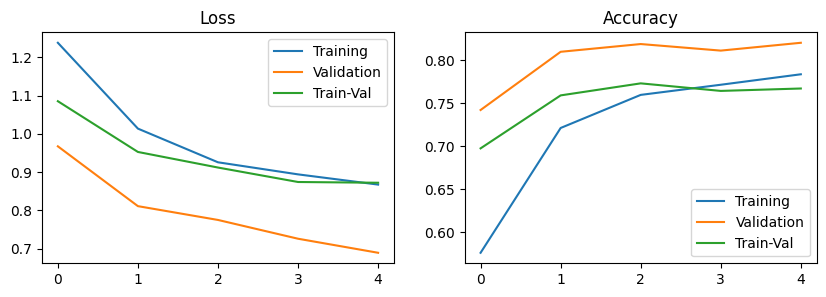

In [56]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = SiameseModelV1()
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)

if torch.cuda.device_count() > 1:
    #print("Using", torch.cuda.device_count(), "GPUs.")
    model = nn.DataParallel(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
trainer = Trainer(model, device, optimizer, criterion)

start = time.time()
trainer.fit(
    epochs=5,
    save_every=5,
    train_loader=train_loader,
    val_loader=val_loader,
    train_val_loader=train_val_loader,
)
end = time.time()

In [58]:
print("Time taken: ", end - start)

Time taken:  831.9201757907867
